In [3]:
# load your csv file into dataframe
# data processing and calculation tools
import pandas as pd
import numpy as np
import plotly.express as px
# Specify the path to your CSV file

# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv('Cryptoquant_Eth_Hour_base-fee.csv')
df2 = pd.read_csv('Cryptoquant_Eth_OHLC_Spot_1h.csv')
# Define the desired start date
start_date = '2020-12-01'

# Filter the DataFrame based on the desired start date
df = df[df['datetime'] >= start_date]
df2 = df2[df2['datetime'] >= start_date]
print(df)
df['close'] = df2['close']

df['price_chg'] = df2['close'].pct_change()


       Unnamed: 0             datetime     start_time       end_time  \
4896         4896  2020-12-01 00:00:00  1606780800000  1606784399000   
4897         4897  2020-12-01 01:00:00  1606784400000  1606787999000   
4898         4898  2020-12-01 02:00:00  1606788000000  1606791599000   
4899         4899  2020-12-01 03:00:00  1606791600000  1606795199000   
4900         4900  2020-12-01 04:00:00  1606795200000  1606798799000   
...           ...                  ...            ...            ...   
35060       35060  2024-05-10 20:00:00  1715371200000  1715374799000   
35061       35061  2024-05-10 21:00:00  1715374800000  1715378399000   
35062       35062  2024-05-10 22:00:00  1715378400000  1715381999000   
35063       35063  2024-05-10 23:00:00  1715382000000  1715385599000   
35064       35064  2024-05-11 00:00:00  1715385600000  1715389199000   

       base_fee_mean  
4896             NaN  
4897             NaN  
4898             NaN  
4899             NaN  
4900             NaN

In [4]:
def backtesting(rolling_window, z_score_threshold, sr_multiplier, fees, backtest_mode):
    # z_score calculation
    # rolling mean
    
    

    
    df['sma'] = df['base_fee_mean'].rolling(window=rolling_window).mean()
    # rolling std
    df['rolling_std'] = df['base_fee_mean'].rolling(window=rolling_window).std()
    # zscore = (closeprice - mean) / std
    df['z_score'] = (df['base_fee_mean'] - df['sma']) / df['rolling_std']
    
    # convert zscore into array and convert NaN to 0.0
    not_clean_z_score = df["z_score"].values
    z_score = np.nan_to_num(not_clean_z_score)
    position = np.array([0.0] * len(df))

    # position entry exit logic
    long_trade = 0
    short_trade = 0
    # loopp all the zscore for entry and exit based on z_score

    if backtest_mode == "trend":
        for i in range(rolling_window, len(position)):
            if z_score[i] > z_score_threshold: #zscore > thresh
                position[i] = 1 
                # previous position = 0 or -1 , current position = 1
                if position[i-1] != position[i]:
                    long_trade += 1
            else : position[i] = 0
            # elif z_score[i] <= z_score_threshold * -1.0: # 1 * -1.0 = -1
            #     position[i] = -1
            #     # previous position = 1 or 0, current position = -1
            #     if position[i-1] != position[i]:
            #         short_trade += 1
            # else:
            #     position[i] = position[i-1] # previous position = 1, current position = 1
    else:
        for i in range(rolling_window, len(position)):
            if z_score[i] >= z_score_threshold:
                position[i] = -1
                # previous position = 1 or 0, current position = -1
                if position[i-1] != position[i]:
                    short_trade += 1
            elif z_score[i] <= z_score_threshold * -1.0: # 1 * -1.0 = -1
                position[i] = 1
                # previous position = 0 or -1 , current position = 1
                if position[i-1] != position[i]:
                    long_trade += 1
            else:
                position[i] = position[i-1] # previous position = 1, current position = 1


    # trades and pnl calculation
    # After done entry and exit logic
    # Calculate performance 
    interval_pnl = [0]
    trades = [0]
    # get the trades
    for i in range(1,len(df)):
        # if previous position is not same as current position , mean got trade executed
        # example, previous position = 0, current position = -1 , trades = 0 - (-1) = 1
        # previous position = 0, current position = 1 , trades = 0 - 1 = abs(-1) = 1
        # previous position = 1, current position = -1 , trades = 1 - (-1) = abs(2) = 2
        # previous position = -1, current position = 1 , trades = -1 - 1 = abs(-2) = 2
        if position[i-1] != position[i]:
            trades.append(abs(position[i-1] - position[i]))
        else:
            trades.append(0)
    # calculate the PnL by using trades and position, and also fees 
    price_change = df['price_chg'].values
    for i in range(1,len(df)):
        interval_pnl.append(position[i-1] * price_change[i] - trades[i] * fees / 100)  #每天的浮盈加起来
    df['pnl'] = interval_pnl
    df['position'] = position
    df['trade'] = trades
    df['cumu'] = df['pnl'].cumsum()


    # performance report
    mdd = min(interval_pnl)
    # mean of PnL
    mean = np.mean(interval_pnl)
    # standard deviation of PnL
    stddev = np.std(interval_pnl)

    # SR multiplier => daily data = 365 * 1
    #                  1 hour data = 365 * 24
    # Sharpe ratio = mean of pnl / std of pnl * square root of (365 * sr_multiplier)
    sharpe_ratio = mean / stddev * np.sqrt(365 * sr_multiplier)
    # Performance report
    data = {
            'rolling_window': rolling_window,
            'z_score_threshold': z_score_threshold,
            'num_of_trades': np.sum(trades),
            'long_trades': long_trade,
            'short_trades': short_trade,
            'cumu': df['cumu'].iat[-1],
            'AR': mean * 365 * sr_multiplier,
            'MDD': mdd,
            'CR': mean * 365 * sr_multiplier / abs(mdd),
            'SR': sharpe_ratio 
        }

    return data

In [66]:
import matplotlib.pyplot as plt
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
print(df.columns)
# 创建图形和坐标轴
fig, ax1 = plt.subplots(figsize=(12, 6))

# 绘制第一个数据集的折线图
ax1.plot(df['datetime'], df['range_100inf_inflow'], label='range_100inf_inflow PnL', color='blue')
ax1.set_xlabel('Time', color='black')
ax1.set_ylabel('range_100inf_inflow', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.tick_params(axis='x', labelcolor='black')

# 创建共享X轴的第二个Y轴，并绘制第二个数据集的折线图
ax2 = ax1.twinx()
ax2.plot(df.index, df['close'], label='Close Price', color='black')
ax2.set_ylabel('Close Price', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# 添加标题和图例
fig.suptitle('Backtest Result: range_100inf_inflow and Close Price', color='black')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), frameon=False, fontsize=10, title_fontsize='13', title='Legend')
ax1.grid(True)

# 显示图形
plt.show()

Index(['range_100_1k_percent', 'range_01_1', 'range_100_1k', 'range_10_100',
       'range_1k_10k', 'range_1k_10k_percent', 'range_001_01_percent',
       'range_0_001', 'start_time', 'datetime', 'range_10k_inf', 'end_time',
       'range_1_10_percent', 'range_001_01', 'range_10_100_percent',
       'range_01_1_percent', 'range_10k_inf_percent', 'range_1_10',
       'range_0_001_percent', 'close', 'price_chg', 'range_100inf_inflow',
       'range_100inf_utx', 'range_0100_utx', 'del_utx'],
      dtype='object')


KeyboardInterrupt: 

In [8]:

df['sma'] = df['staking_inflow_total'].rolling(window=15).mean()
    # rolling std
df['rolling_std'] = df['staking_inflow_total'].rolling(window=15).std()
    # zscore = (closeprice - mean) / std
df['z_score'] = (df['staking_inflow_total'] - df['sma']) / df['rolling_std']
    
fig = px.line(data_frame=df, x='date', y='z_score')
fig.show()


trend
   rolling_window  z_score_threshold  num_of_trades  long_trades  \
0               5               -2.0            1.0            1   

   short_trades  cumu  AR       MDD  CR  SR  
0             0   NaN NaN -0.152851 NaN NaN  
   rolling_window  z_score_threshold  num_of_trades  long_trades  \
0               5              -2.00            1.0            1   
1               5              -1.75           59.0           30   

   short_trades  cumu  AR       MDD  CR  SR  
0             0   NaN NaN -0.152851 NaN NaN  
1             0   NaN NaN -0.152851 NaN NaN  
   rolling_window  z_score_threshold  num_of_trades  long_trades  \
0               5              -2.00            1.0            1   
1               5              -1.75           59.0           30   
2               5              -1.50         1265.0          633   

   short_trades  cumu  AR       MDD  CR  SR  
0             0   NaN NaN -0.152851 NaN NaN  
1             0   NaN NaN -0.152851 NaN NaN  
2          

c:\Users\user\anaconda3\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\user\anaconda3\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


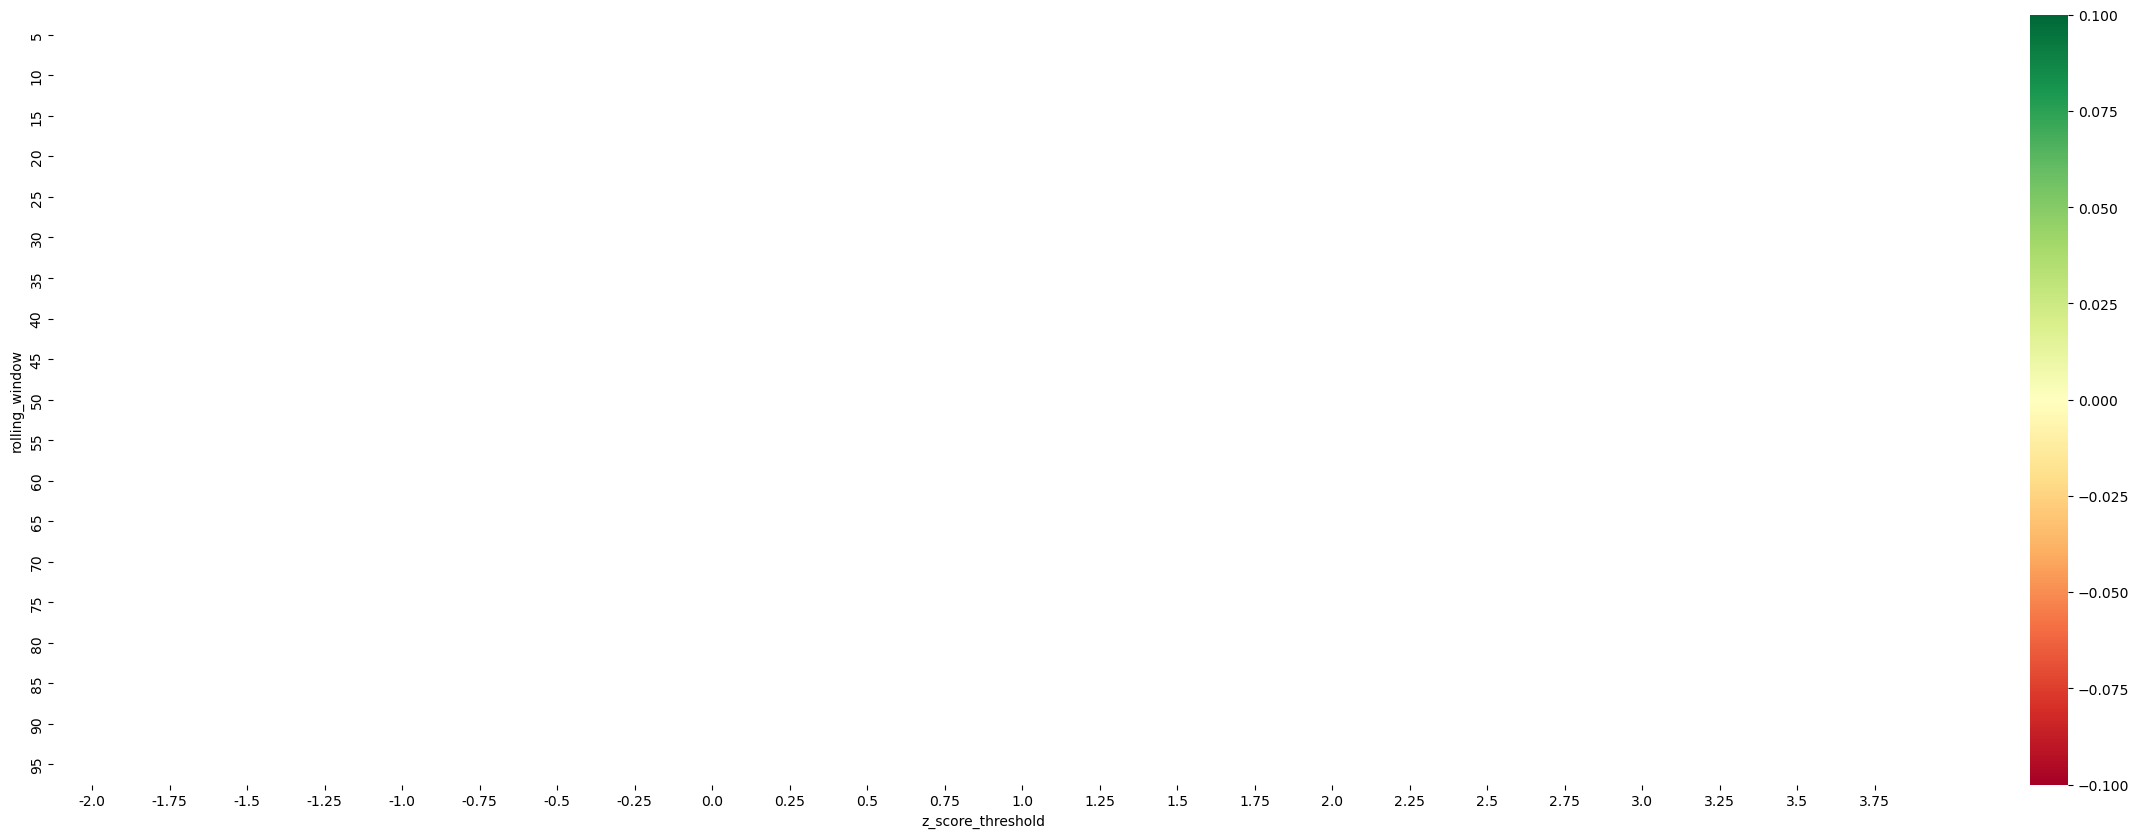

mr
   rolling_window  z_score_threshold  num_of_trades  long_trades  \
0               5               -2.0            1.0            0   

   short_trades  cumu  AR       MDD  CR  SR  
0             1   NaN NaN -0.081786 NaN NaN  
   rolling_window  z_score_threshold  num_of_trades  long_trades  \
0               5              -2.00            1.0            0   
1               5              -1.75          117.0           29   

   short_trades  cumu  AR       MDD  CR  SR  
0             1   NaN NaN -0.081786 NaN NaN  
1            30   NaN NaN -0.081786 NaN NaN  
   rolling_window  z_score_threshold  num_of_trades  long_trades  \
0               5              -2.00            1.0            0   
1               5              -1.75          117.0           29   
2               5              -1.50         2529.0          632   

   short_trades  cumu  AR       MDD  CR  SR  
0             1   NaN NaN -0.081786 NaN NaN  
1            30   NaN NaN -0.081786 NaN NaN  
2           63

c:\Users\user\anaconda3\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\user\anaconda3\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


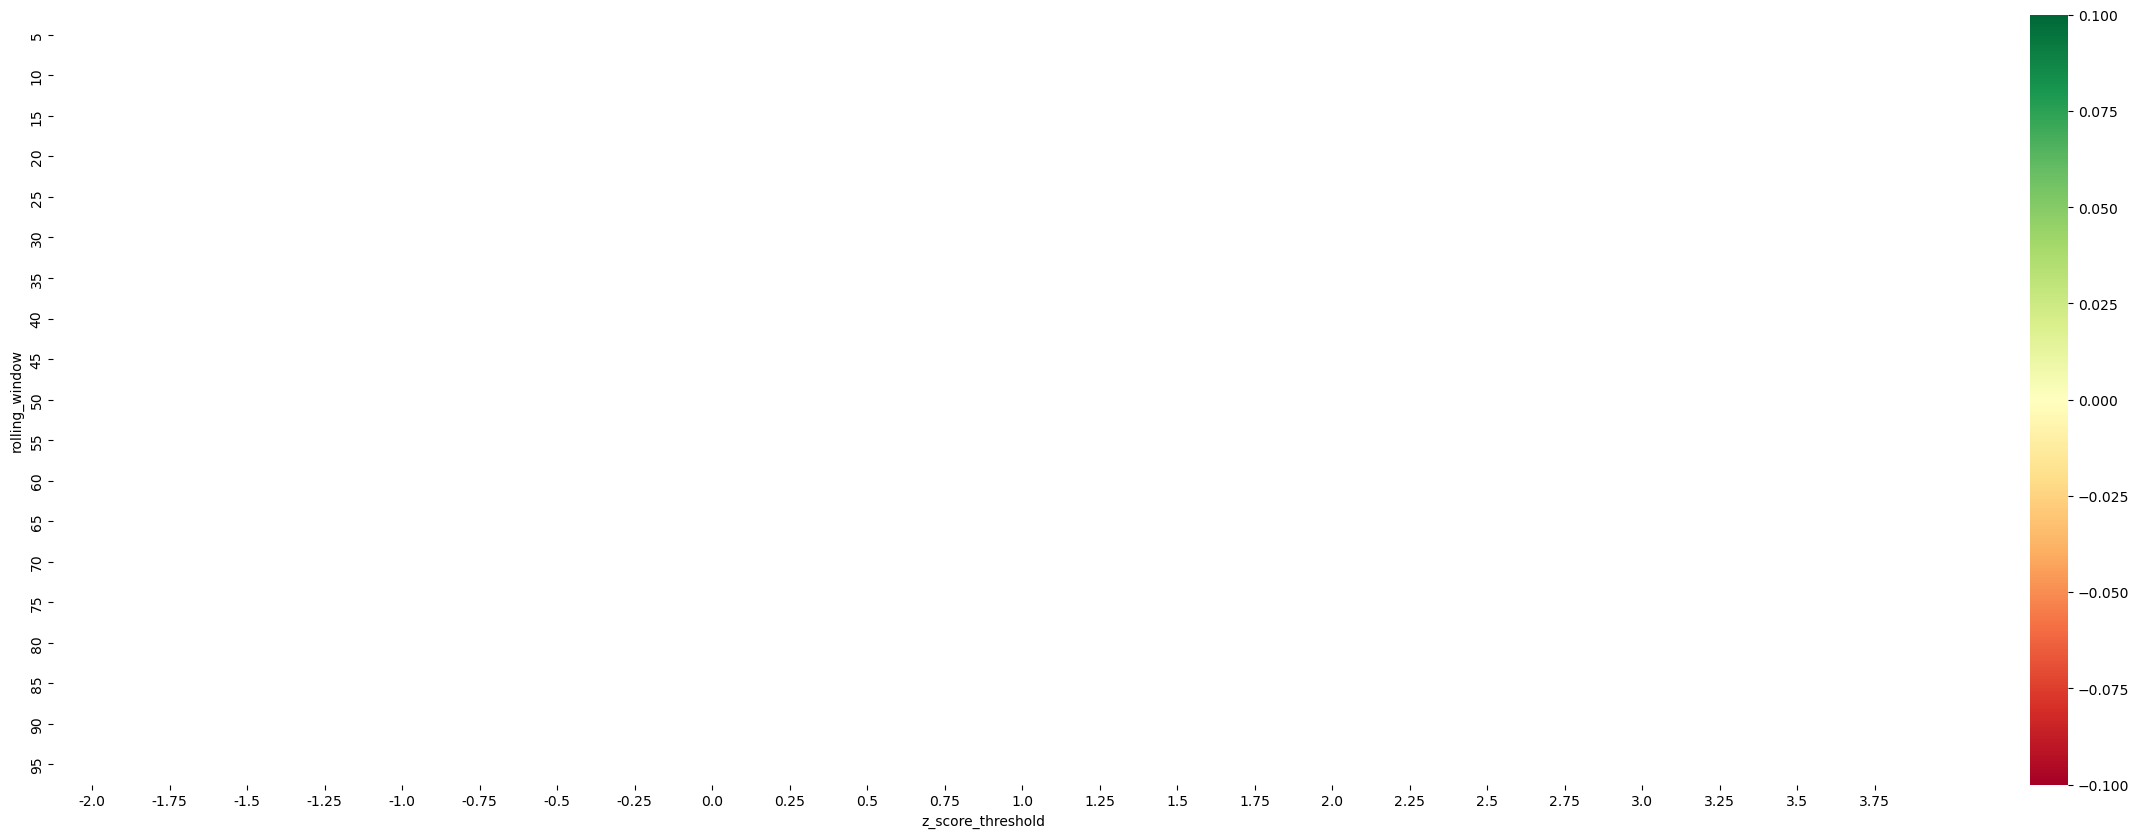

In [5]:
# loop all params needed to backtest 
rolling_window_array = np.arange(5, 100, 5)
z_score_threshold_array = np.arange(-2, 4, 0.25)
backtest_mode_arr = ["trend", "mr"]
for backtest_mode in backtest_mode_arr:
    print(backtest_mode)
    all_result = []
    for rolling_window in rolling_window_array:
        for z_score_threshold in z_score_threshold_array:
            backtest_1 = backtesting(rolling_window=rolling_window, z_score_threshold=z_score_threshold, sr_multiplier=24, fees=0.06, backtest_mode=backtest_mode)
            # print(backtest_1)
            if backtest_mode == 'trend' :
                all_result.append(backtest_1)
                all_sr = pd.DataFrame(all_result)
                print(all_sr)
            
            else :
                all_result.append(backtest_1)
                second = pd.DataFrame(all_result)
                print(second)
            
   
    
    
    df_pivot = all_sr.pivot(index="rolling_window",columns ='z_score_threshold', values="SR")
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    # Create a heatmap
    plt.figure(figsize=(30, 10))
    sns.heatmap(df_pivot,annot=True, cmap='RdYlGn')
    
    # Show the plot
    plt.show()

c:\Users\user\anaconda3\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\user\anaconda3\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


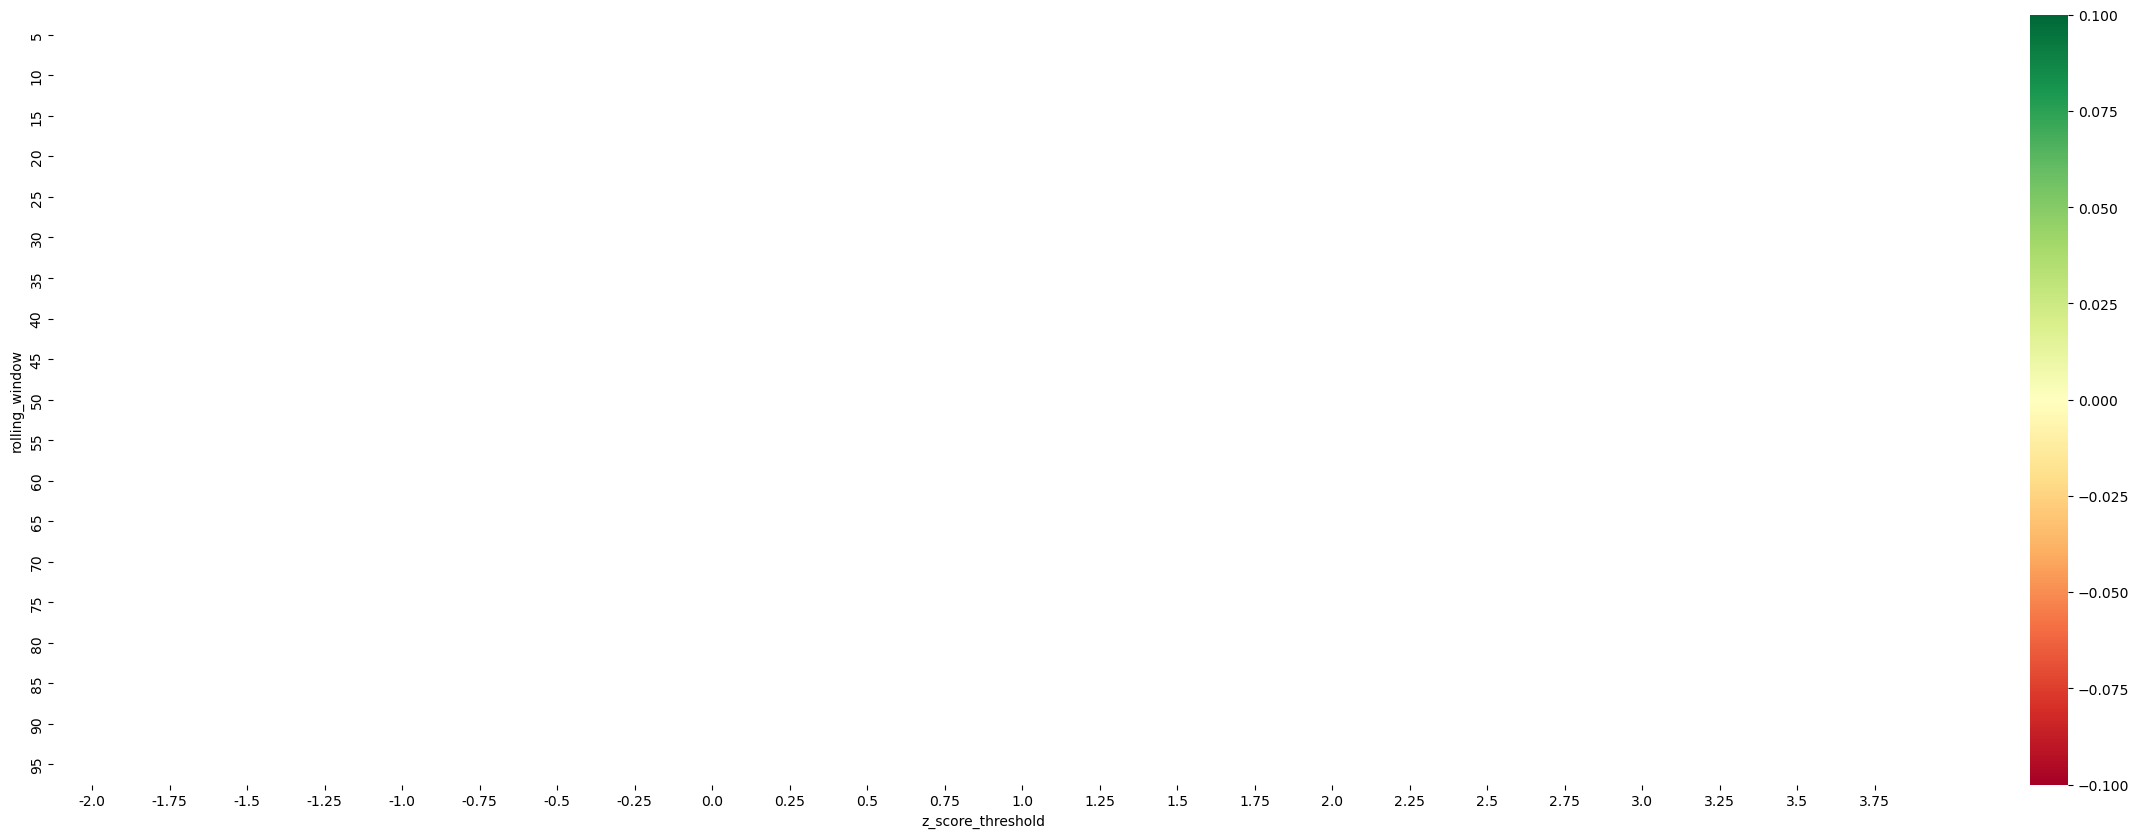

In [6]:

df_pivot1 = second.pivot(index="rolling_window",columns ='z_score_threshold', values="SR")
import matplotlib.pyplot as plt
import seaborn as sns
# Create a heatmap
plt.figure(figsize=(30, 10))
sns.heatmap(df_pivot1,annot=True, cmap='RdYlGn')
# Show the plot
plt.show()

In [ ]:
backtest_1 = backtesting(rolling_window=50,z_score_threshold=1,sr_multiplier=1,fees=0)
print(backtest_1)